In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import statsmodels.api as sm
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_dbt = pd.read_csv('./data/diabetes_binary_health_indicators_BRFSS2015.csv')
print(df_dbt.shape)

(253680, 22)


In [3]:
df_dbt.head(2)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0


In [4]:
df_dbt['Diabetes_binary'].value_counts(dropna=False, normalize=True)

0.0    0.860667
1.0    0.139333
Name: Diabetes_binary, dtype: float64

# Split Data to Train/Test

In [5]:
df_train, df_test = train_test_split(df_dbt, test_size=0.2, random_state=42)


X = df_dbt.drop('Diabetes_binary', axis=1)
y = df_dbt[['Diabetes_binary']]

X_train = df_train.drop('Diabetes_binary', axis=1)
X_test = df_test.drop('Diabetes_binary', axis=1)

y_train = df_train[['Diabetes_binary']]
y_test = df_test[['Diabetes_binary']]

print(X_train.shape, X_test.shape)

(202944, 21) (50736, 21)


In [6]:
y_test.value_counts(normalize=True)

Diabetes_binary
0.0                0.86209
1.0                0.13791
dtype: float64

# Data Preprocessing

In [7]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
X_train_scaled.index = X_train.index
X_train_scaled.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
31141,0.0,1.0,1.0,0.093023,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.25,0.0,0.000000,0.0,1.0,0.916667,1.0,1.000000
98230,0.0,0.0,1.0,0.255814,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.50,0.0,0.000000,0.0,1.0,0.583333,0.8,1.000000
89662,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.25,0.0,0.166667,0.0,1.0,0.916667,0.8,0.714286
208255,0.0,1.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.00,0.0,0.000000,0.0,1.0,0.333333,1.0,0.857143
233415,0.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.50,0.0,0.000000,1.0,0.0,0.916667,0.6,0.714286


In [8]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = X_test.columns
X_test_scaled.index = X_test.index
X_test_scaled.head(2)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
219620,0.0,0.0,1.0,0.104651,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.5,0.1,0.233333,0.0,0.0,0.5,0.6,0.142857
132821,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.5,0.0,0.000000,0.0,0.0,1.0,1.0,0.714286


# Modeling

In [9]:
results = pd.DataFrame(columns=['Model', 'Train Score', 'CV Score', 'Test Score', 'Params'])


## Logistic Rergession

In [10]:
model_name = 'Logistic Regression'
model_idx = 0

model = LogisticRegression(random_state=42, max_iter=500)

param_grids = {'penalty': [None, 'l2'], 
               'C': [0.01, 0.1, 1, 10]}

grid_search = GridSearchCV(model, param_grids, cv=5, scoring='f1_macro')
grid_search.fit(X_train_scaled, y_train)

# train_score = f1_score(y_train, grid_search.predict(X_train_scaled), average='macro')
cv_score = grid_search.best_score_
# test_score = f1_score(y_test, grid_search.predict(X_test_scaled), average='macro')

# results.loc[model_idx] = [model_name, train_score, cv_score, test_score, grid_search.best_params_]
model_lr = grid_search.best_estimator_

In [11]:
model_lr.intercept_

array([-6.5016624])

In [12]:
# find the right threshold for cutting prediction
y_pred = model_lr.predict_proba(X_train_scaled)[:, 1]
list_f1score_lr = []
for i in np.arange(0, 1, 0.01):
    
    list_f1score_lr.append(f1_score(y_train, y_pred>=i, average='macro'))

ind_lr = np.argmax(list_f1score_lr)

f1_thresh_lr = np.arange(0, 1, 0.01)[ind_lr]
print(f1_thresh_lr)

train_score = f1_score(y_train, model_lr.predict_proba(X_train_scaled)[:, 1]>f1_thresh_lr, average='macro')
test_score = f1_score(y_test, model_lr.predict_proba(X_test_scaled)[:, 1]>f1_thresh_lr, average='macro')
results.loc[model_idx] = [model_name, train_score, cv_score, test_score, grid_search.best_params_]
results

0.25


,Model,Train Score,CV Score,Test Score,Params
0,Logistic Regression,0.673782,0.581492,0.672803,"{'C': 0.01, 'penalty': None}"


In [13]:
y_pred = model_lr.predict_proba(X_test_scaled)[:, 1]
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred>f1_thresh_lr))
print(classification_report(y_test, y_pred>f1_thresh_lr))

Confusion Matrix:
 [[37901  5838]
 [ 3243  3754]]
              precision    recall  f1-score   support

         0.0       0.92      0.87      0.89     43739
         1.0       0.39      0.54      0.45      6997

    accuracy                           0.82     50736
   macro avg       0.66      0.70      0.67     50736
weighted avg       0.85      0.82      0.83     50736



In [14]:
y_pred = model_lr.predict_proba(X_test_scaled)[:, 1]
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred>f1_thresh_lr))
print(classification_report(y_test, y_pred>f1_thresh_lr))

Confusion Matrix:
 [[37901  5838]
 [ 3243  3754]]
              precision    recall  f1-score   support

         0.0       0.92      0.87      0.89     43739
         1.0       0.39      0.54      0.45      6997

    accuracy                           0.82     50736
   macro avg       0.66      0.70      0.67     50736
weighted avg       0.85      0.82      0.83     50736



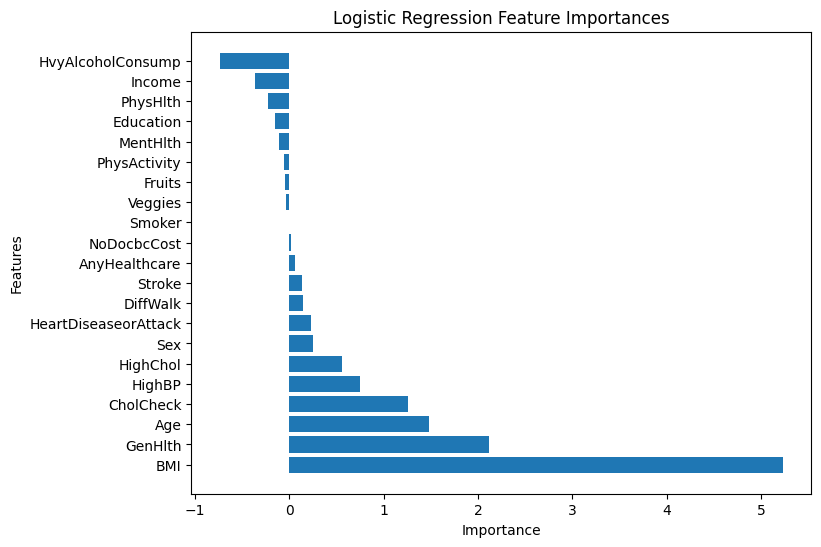

In [15]:
# Create DataFrame and sort
feature_df = pd.DataFrame({'feature': model_lr.feature_names_in_, 'importance': model_lr.coef_[0]})
feature_df = feature_df.sort_values(by='importance', ascending=False)  

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_df['feature'], feature_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title(f'Logistic Regression Feature Importances')
plt.show()

In [16]:
feature_df

,feature,importance
3,BMI,5.232240
13,GenHlth,2.121138
18,Age,1.478829
2,CholCheck,1.254211
0,HighBP,0.749132
1,HighChol,0.561362
17,Sex,0.258371
6,HeartDiseaseorAttack,0.234100
16,DiffWalk,0.144189
5,Stroke,0.141845


In [17]:
feature_df['importance_abs'] = abs(feature_df['importance'])
feature_df.sort_values('importance_abs', ascending=False)

,feature,importance,importance_abs
3,BMI,5.232240,5.232240
13,GenHlth,2.121138,2.121138
18,Age,1.478829,1.478829
2,CholCheck,1.254211,1.254211
0,HighBP,0.749132,0.749132
10,HvyAlcoholConsump,-0.735766,0.735766
1,HighChol,0.561362,0.561362
20,Income,-0.359174,0.359174
17,Sex,0.258371,0.258371
6,HeartDiseaseorAttack,0.234100,0.234100


### using SM

In [18]:
logit_model = sm.Logit(y_train, sm.add_constant(X_train_scaled))
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.320710
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:        Diabetes_binary   No. Observations:               202944
Model:                          Logit   Df Residuals:                   202922
Method:                           MLE   Df Model:                           21
Date:                Thu, 21 Mar 2024   Pseudo R-squ.:                  0.2069
Time:                        13:40:45   Log-Likelihood:                -65086.
converged:                       True   LL-Null:                       -82070.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -6.5022      0.095    -68.352      0.000      -6.689      -6.316

## Decision Tree

In [19]:
model_name = 'Decision Tree'
model_idx = 1

model = DecisionTreeClassifier(random_state=42)

param_grids = {'max_depth': [3, 5,
                             7, 9, 11],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'criterion': ['gini', 'entropy']}

grid_search = GridSearchCV(model, param_grids, cv=5, scoring='f1_macro')
grid_search.fit(X_train_scaled, y_train)

# train_score = f1_score(y_train, grid_search.predict(X_train_scaled), average='macro')
cv_score = grid_search.best_score_
# test_score = f1_score(y_test, grid_search.predict(X_test_scaled), average='macro')

# results.loc[model_idx] = [model_name, train_score, cv_score, test_score, grid_search.best_params_]
model_dt = grid_search.best_estimator_

In [20]:
model_name = 'Decision Tree'
model_idx = 1

# find the right threshold for cutting prediction
y_pred = model_dt.predict_proba(X_train_scaled)[:, 1]
list_f1score_dt = []
for i in np.arange(0, 1, 0.01):
    
    list_f1score_dt.append(f1_score(y_train, y_pred>=i, average='macro'))

ind_dt = np.argmax(list_f1score_dt)

f1_thresh_dt = np.arange(0, 1, 0.01)[ind_dt]
print(f1_thresh_dt)

train_score = f1_score(y_train, model_dt.predict_proba(X_train_scaled)[:, 1]>f1_thresh_dt, average='macro')
test_score = f1_score(y_test, model_dt.predict_proba(X_test_scaled)[:, 1]>f1_thresh_dt, average='macro')
results.loc[model_idx] = [model_name, train_score, cv_score, test_score, grid_search.best_params_]
results

0.29


,Model,Train Score,CV Score,Test Score,Params
0,Logistic Regression,0.673782,0.581492,0.672803,"{'C': 0.01, 'penalty': None}"
1,Decision Tree,0.699446,0.585383,0.670873,"{'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 10}"


In [21]:
y_pred = model_dt.predict_proba(X_test_scaled)[:, 1]
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred>f1_thresh_dt))
print(classification_report(y_test, y_pred>f1_thresh_dt))

Confusion Matrix:
 [[38280  5459]
 [ 3425  3572]]
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90     43739
         1.0       0.40      0.51      0.45      6997

    accuracy                           0.82     50736
   macro avg       0.66      0.69      0.67     50736
weighted avg       0.85      0.82      0.83     50736



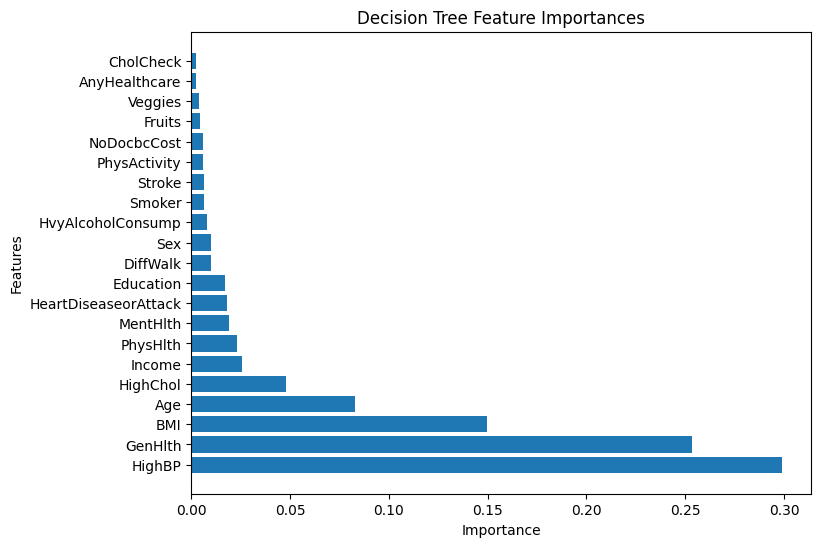

In [22]:
# Extract feature importances
importances = model_dt.feature_importances_

# Create DataFrame and sort
feature_df = pd.DataFrame({'feature': X_train_scaled.columns, 'importance': importances})
feature_df = feature_df.sort_values(by='importance', ascending=False)  

# Plot the feature importances
plt.figure(figsize=(8, 6)) 
plt.barh(feature_df['feature'], feature_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title(f'Decision Tree Feature Importances')
plt.show()

In [23]:
feature_df

,feature,importance
0,HighBP,0.298952
13,GenHlth,0.253291
3,BMI,0.149555
18,Age,0.083001
1,HighChol,0.047690
20,Income,0.025387
15,PhysHlth,0.022906
14,MentHlth,0.018947
6,HeartDiseaseorAttack,0.017918
19,Education,0.017062


## Random Forest

In [24]:
# This cell takes time about 35 minutes.

model_name = 'Random Forest'
model_idx = 2

model = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grids = {'n_estimators': [50, 100, 200,
                                300, 500],
                'min_samples_leaf': [1, 2, 4],
                 'min_samples_split': [2, 5, 10],
               'max_depth': [3, 5, 7, 9, 11]}

grid_search = GridSearchCV(model, param_grids, cv=5, scoring='f1_macro')
grid_search.fit(X_train_scaled, y_train)

# train_score = f1_score(y_train, grid_search.predict(X_train_scaled), average='macro')
cv_score = grid_search.best_score_
# test_score = f1_score(y_test, grid_search.predict(X_test_scaled), average='macro')

# results.loc[model_idx] = [model_name, train_score, cv_score, test_score, grid_search.best_params_]
model_rf = grid_search.best_estimator_

In [25]:
model_name = 'Random Forest'
model_idx = 2

# find the right threshold for cutting prediction
y_pred = model_rf.predict_proba(X_train_scaled)[:, 1]
list_f1score_rf = []
for i in np.arange(0, 1, 0.01):
    
    list_f1score_rf.append(f1_score(y_train, y_pred>=i, average='macro'))

ind_rf = np.argmax(list_f1score_rf)

f1_thresh_rf = np.arange(0, 1, 0.01)[ind_rf]
print(f1_thresh_rf)

train_score = f1_score(y_train, model_rf.predict_proba(X_train_scaled)[:, 1]>f1_thresh_rf, average='macro')
test_score = f1_score(y_test, model_rf.predict_proba(X_test_scaled)[:, 1]>f1_thresh_rf, average='macro')
results.loc[model_idx] = [model_name, train_score, cv_score, test_score, grid_search.best_params_]
results

0.28


,Model,Train Score,CV Score,Test Score,Params
0,Logistic Regression,0.673782,0.581492,0.672803,"{'C': 0.01, 'penalty': None}"
1,Decision Tree,0.699446,0.585383,0.670873,"{'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 10}"
2,Random Forest,0.702335,0.550162,0.681037,"{'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}"


In [26]:
y_pred = model_rf.predict_proba(X_test_scaled)[:, 1]
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred>f1_thresh_rf))
print(classification_report(y_test, y_pred>f1_thresh_rf))

Confusion Matrix:
 [[38868  4871]
 [ 3463  3534]]
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90     43739
         1.0       0.42      0.51      0.46      6997

    accuracy                           0.84     50736
   macro avg       0.67      0.70      0.68     50736
weighted avg       0.85      0.84      0.84     50736



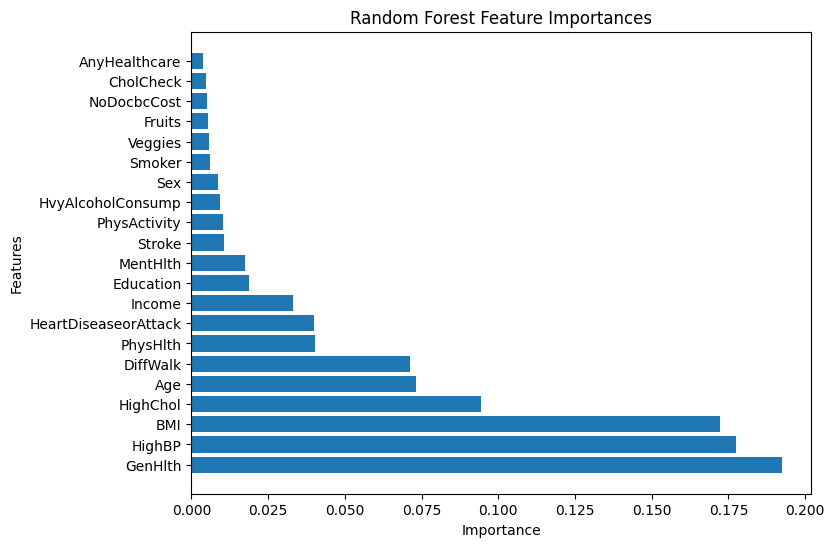

In [27]:
# Extract feature importances
importances = model_rf.feature_importances_

# Create DataFrame and sort
feature_df = pd.DataFrame({'feature': X_train_scaled.columns, 'importance': importances})
feature_df = feature_df.sort_values(by='importance', ascending=False)  

# Plot the feature importances
plt.figure(figsize=(8, 6)) 
plt.barh(feature_df['feature'], feature_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title(f'Random Forest Feature Importances')
plt.show()

In [28]:
feature_df

,feature,importance
13,GenHlth,0.192421
0,HighBP,0.177578
3,BMI,0.172338
1,HighChol,0.094231
18,Age,0.073164
16,DiffWalk,0.071133
15,PhysHlth,0.040266
6,HeartDiseaseorAttack,0.039965
20,Income,0.033146
19,Education,0.018843


## Save models

In [29]:
# save trained models
model_pkl_file = "./models/data583_2classdiabetes_3models_minmax.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model_lr, file)
    pickle.dump(model_dt, file)
    pickle.dump(model_rf, file)
    pickle.dump(scaler, file)
    

In [30]:
# load trained models
model_pkl_file = "./models/data583_2classdiabetes_3models_minmax.pkl"  

file = open(model_pkl_file,'rb')
model_lr = pickle.load(file)
model_dt = pickle.load(file)
model_rf = pickle.load(file)
scaler = pickle.load(file)
file.close()


## All models performance

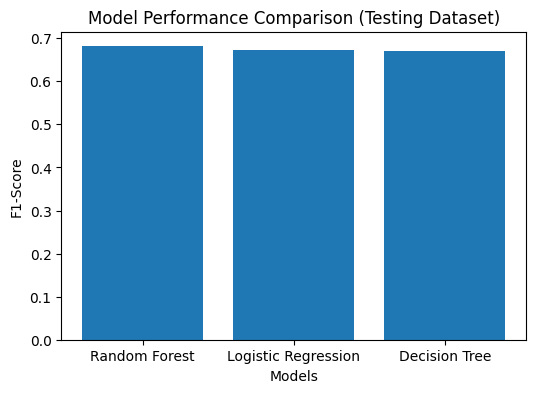

In [31]:
results = results.sort_values('Test Score', ascending=False)
plt.figure(figsize=(6, 4))
plt.bar(results['Model'], results['Test Score'])
plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.title('Model Performance Comparison (Testing Dataset)')
plt.show()

In [32]:
results.drop(columns='CV Score')
# CV Score auto-cut the prediction with a threshold equals to 0.5.

,Model,Train Score,Test Score,Params
2,Random Forest,0.702335,0.681037,"{'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}"
0,Logistic Regression,0.673782,0.672803,"{'C': 0.01, 'penalty': None}"
1,Decision Tree,0.699446,0.670873,"{'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 10}"


My models have the performance of F1-Scores higher than this work in the Kaggle.
https://www.kaggle.com/code/ohoodalsohaime/diabetes-indicators-classfication-project-part1